# LSTM - Predicting Trend
In this notebook, an attempt of capturing a trend in data is presented. Can the LSTM model be used to correctly predict what will be the vague trend over the next X days, not only the next day?

In order to use the notebook, you need to have a config.json and a folder named "data" with a file close_volume.csv (or a different name, specified in config.json). The file, as the name implies, needs to have the columns "Close" and "Volume" (as specified in config.json as well).


This notebook is an extension of the original project created by Jakob Aungiers, published under the MIT license in 2018, available under the following link:

https://github.com/jakob-aungiers/LSTM-Neural-Network-for-Time-Series-Prediction

Modifications were made by Bartłomiej Czech. The model was converted to TensorFlow 2 and its functionality was enhanced through integrating all parts of it into a single notebook, modifying the existing methods, greater readability and automatization, as well as adding an algorithm for comparing the investment strategy against actual stock returns and plotting them.

In [ ]:
# The only thing you need to do for this notebook to work is to:
# 1. Create a folder "data"
# 2. Have a file named ticker + _close_volume.csv in it, for example amzn_close_volume.csv
# 3. Specify this ticker here:
ticker = "sp500"

# The notebook's dataflow should be now uninterrupted.

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

class DataLoader:
    """A class for loading and transforming data for LSTM models"""

    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe[cols].values[:i_split]
        self.data_test = dataframe[cols].values[i_split:]
        self.len_train = len(self.data_train)
        self.len_test = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise=True):
        '''
        Create x, y test data windows.
        '''
        data_windows = [
            self.data_test[i:i+seq_len]
            for i in range(self.len_test - seq_len)
        ]

        data_windows = np.array(data_windows).astype(np.float32)
        if normalise:
            data_windows = self.normalise_windows(data_windows, single_window=False)

        x = data_windows[:, :-1]  # All except the last step
        y = data_windows[:, -1, [0]]  # Target value (last step, first feature)
        return x, y

    def get_train_data(self, seq_len, normalise=True):
        '''
        Create x, y train data windows.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)

        return np.array(data_x, dtype=np.float32), np.array(data_y, dtype=np.float32)

    def generate_train_batch(self, seq_len, batch_size, normalise=True):
        '''Yield a generator of training data.'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    yield np.array(x_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1

            yield np.array(x_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i.'''
        window = self.data_train[i:i+seq_len]
        if normalise:
            window = self.normalise_windows(window, single_window=True)[0]

        x = window[:-1]  # All except the last step
        y = window[-1, [0]]  # Target value (last step, first feature)
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero.'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        i = 0
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                base_value = float(window[0, col_i]) if window[0, col_i] != 0 else 1.0
                normalised_col = [(float(p) / base_value) - 1 for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T  # Reshape and transpose array
            normalised_data.append(normalised_window)

        return np.array(normalised_data, dtype=np.float32)


In [ ]:
import datetime as dt

class Timer:
    """A utility class for measuring time durations."""

    def __init__(self):
        self.start_dt = None

    def start(self):
        """Start the timer."""
        self.start_dt = dt.datetime.now()

    def stop(self):
        """Stop the timer and print the elapsed time."""
        if self.start_dt is None:
            print("Timer was not started. Use `start()` to begin timing.")
            return

        end_dt = dt.datetime.now()
        elapsed_time = end_dt - self.start_dt
        print(f'Time taken: {elapsed_time}')
        self.start_dt = None  # Reset timer for reuse


In [ ]:
import os
import numpy as np
import datetime as dt
from numpy import newaxis
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class Model:
    """A class for building and inferencing an LSTM model"""

    def __init__(self):
        self.model = Sequential()

    def load_model(self, filepath):
        print(f'[Model] Loading model from file {filepath}')
        self.model = load_model(filepath)

    def build_model(self, configs):
        timer = Timer()
        timer.start()

        for layer in configs['model']['layers']:
            neurons = layer.get('neurons')
            dropout_rate = layer.get('rate')
            activation = layer.get('activation')
            return_seq = layer.get('return_seq', False)
            input_timesteps = layer.get('input_timesteps')
            input_dim = layer.get('input_dim')

            if layer['type'] == 'dense':
                self.model.add(Dense(neurons, activation=activation))
            elif layer['type'] == 'lstm':
                self.model.add(
                    LSTM(
                        neurons,
                        input_shape=(input_timesteps, input_dim),
                        return_sequences=return_seq,
                    )
                )
            elif layer['type'] == 'dropout':
                self.model.add(Dropout(dropout_rate))

        self.model.compile(
            loss=configs['model']['loss'],
            optimizer=configs['model']['optimizer']
        )

        print('[Model] Model Compiled')
        timer.stop()

    def train(self, x, y, epochs, batch_size, save_dir):
        timer = Timer()
        timer.start()
        print(f'[Model] Training Started')
        print(f'[Model] {epochs} epochs, {batch_size} batch size')

        save_fname = os.path.join(
            save_dir,
            f'{dt.datetime.now().strftime("%d%m%Y-%H%M%S")}-e{epochs}.h5'
        )
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
        ]

        self.model.fit(
            x,
            y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=callbacks
        )
        self.model.save(save_fname)

        print(f'[Model] Training Completed. Model saved as {save_fname}')
        timer.stop()

    def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
        """Train the model using a data generator."""
        timer = Timer()
        timer.start()
        print(f'[Model] Training Started')
        print(f'[Model] {epochs} epochs, {batch_size} batch size, {steps_per_epoch} batches per epoch')

        save_fname = os.path.join(
            save_dir,
            f'{dt.datetime.now().strftime("%d%m%Y-%H%M%S")}-e{epochs}.keras'
        )
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
        ]

        self.model.fit(
            data_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=callbacks
        )

        print(f'[Model] Training Completed. Model saved as {save_fname}')
        timer.stop()


    def predict_point_by_point(self, data):
        # Predict each timestep given the last sequence of true data
        print('[Model] Predicting Point-by-Point...')
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted

    def predict_sequences_multiple(self, data, window_size, prediction_len): # data is x_test, shape
        # Predict sequence of steps before shifting prediction run forward
        print('[Model] Predicting Sequences Multiple...')
        prediction_seqs = []
        for i in range(int(len(data) / prediction_len)):
            curr_frame = data[i * prediction_len]
            predicted = []
            for j in range(prediction_len):
                pred = self.model.predict(curr_frame[newaxis, :, :])[0, 0]
                predicted.append(pred)
                curr_frame = curr_frame[1:]
                curr_frame = np.insert(curr_frame, [window_size - 2], pred, axis=0)
            prediction_seqs.append(predicted)
        return prediction_seqs

    def predict_sequence_full(self, data, window_size):
        # Shift the window by 1 new prediction each time, re-run predictions
        print('[Model] Predicting Sequences Full...')
        curr_frame = data[0]
        predicted = []
        for i in range(len(data)):
            pred = self.model.predict(curr_frame[newaxis, :, :])[0, 0]
            predicted.append(pred)
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size - 2], pred, axis=0)
        return predicted


In [ ]:
import os
import json
import math
import matplotlib.pyplot as plt


def plot_results(predicted_data, true_data):
    """Plots predicted vs. true data."""
    fig = plt.figure(facecolor='white', figsize=(12, 6))  # Adjusted figure size
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data', linewidth=2)  # Added thicker line for True Data
    ax.plot(predicted_data, label='Prediction', linewidth=1.5, linestyle='--')  # Dashed line for Prediction
    ax.legend(loc='upper left', fontsize=10, frameon=True)  # Improved legend readability
    ax.set_title("Predicted vs. True Data", fontsize=14)
    ax.set_xlabel("Time Steps", fontsize=12)
    ax.set_ylabel("Normalized Values", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len, title="Predicted vs. True Data", ylabel="Normalized Values", xlabel="Time Steps"):
    """Plots predicted vs. true data for multiple prediction sequences."""
    fig = plt.figure(facecolor='white', figsize=(14, 8))  # Larger figure size
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data', linewidth=2)
    # Pad the list of predictions to align them correctly on the graph
    for i, data in enumerate(predicted_data):
        padding = [None] * (i * prediction_len)
        ax.plot(padding + data, label=f'Prediction {i + 1}', linewidth=1.2)
    ax.legend(loc='upper left', fontsize=10, frameon=True, ncol=2)  # Moved to upper left and split columns
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()  # Ensure no overlapping elements
    plt.show()

In [ ]:
"""Main execution function."""
# Load configuration
with open('config.json', 'r') as config_file:
    configs = json.load(config_file)

# Ensure model save directory exists
save_dir = configs['model']['save_dir']
os.makedirs(save_dir, exist_ok=True)

# Load and preprocess data
data = DataLoader(
    os.path.join('data', ticker + "_" + configs['data']['filename']),
    configs['data']['train_test_split'],
    configs['data']['columns']
)

# Build and train model
model = Model()
model.build_model(configs)

# Test the model and generate predictions
x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

prex_test, prey_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=False
)

base_values = []
base50later_values = []
for arr in  prex_test:
  base_values.append([arr[0][0], arr[0][1]])
  base50later_values.append([arr[-1][0], arr[-1][1]])

base_values = np.array(base_values)

first_values = base_values[:, 0]

print(first_values[:5])

print(str(len(first_values)))
print(str(len(x_test)))

[Model] Model Compiled
Time taken: 0:00:00.188104
[2023.04 2053.19 2050.44 2083.58 2081.24]
655
655


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


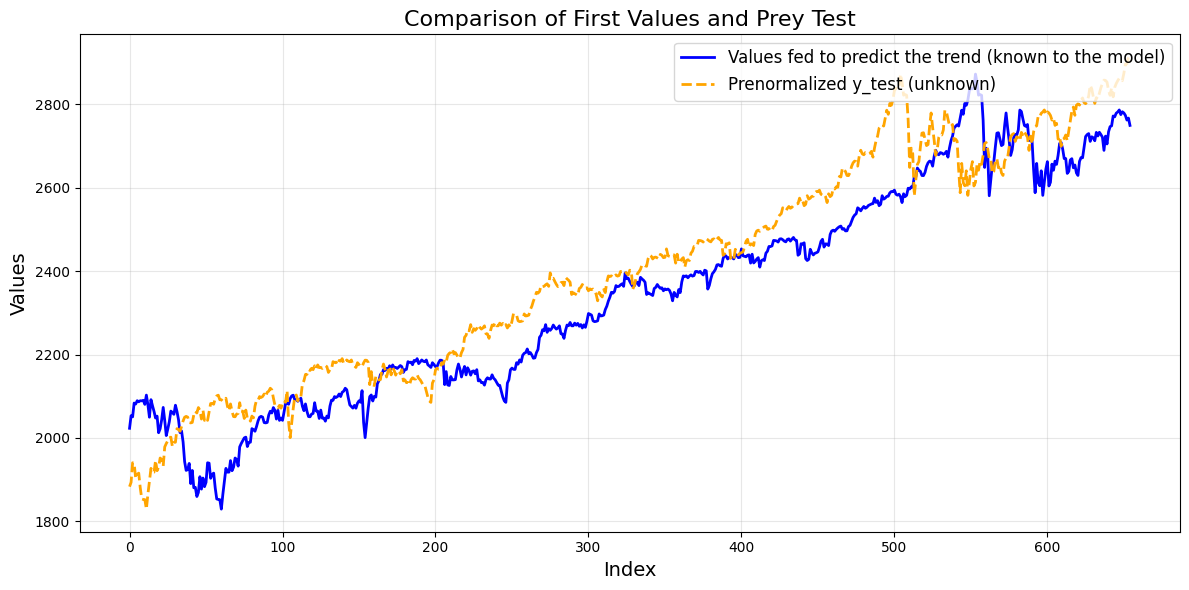

In [ ]:
# Ensure prey_test is flattened for plotting
prey_test = prey_test.flatten()

# Plot both first_values and prey_test
plt.figure(figsize=(12, 6))
plt.plot(first_values, label='Values fed to predict the trend (known to the model)', linewidth=2, color='blue')
plt.plot(prey_test, label='Prenormalized y_test (unknown)', linewidth=2, color='orange', linestyle='--')

# Add title and labels
plt.title("Comparison of First Values and Prey Test", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Generative training
steps_per_epoch = math.ceil(
    (data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size']
)
model.train_generator(
    data_gen=data.generate_train_batch(
        seq_len=configs['data']['sequence_length'],
        batch_size=configs['training']['batch_size'],
        normalise=configs['data']['normalise']
    ),
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    steps_per_epoch=steps_per_epoch,
    save_dir=save_dir
)

# Test the model and generate predictions
x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

# Choose a prediction method
predictions = model.predict_sequences_multiple(
    x_test,
    configs['data']['sequence_length'],
    configs['data']['sequence_length']
)
# predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
# predictions = model.predict_point_by_point(x_test)

[Model] Training Started
[Model] 2 epochs, 32 batch size, 124 batches per epoch
Epoch 1/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - loss: 0.0029
Epoch 2/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 8.1270e-04
[Model] Training Completed. Model saved as saved_models/22112024-115406-e2.keras
Time taken: 0:00:47.274567
[Model] Predicting Sequences Multiple...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━

In [ ]:
den_predictions = []
i = 0
for arr in predictions:
  den_arr = []
  for num in arr:
    den_arr.append((num + 1) * first_values[i]) # We only know first_values, prey_test is unknown
    i += 1

  den_predictions.append(den_arr)

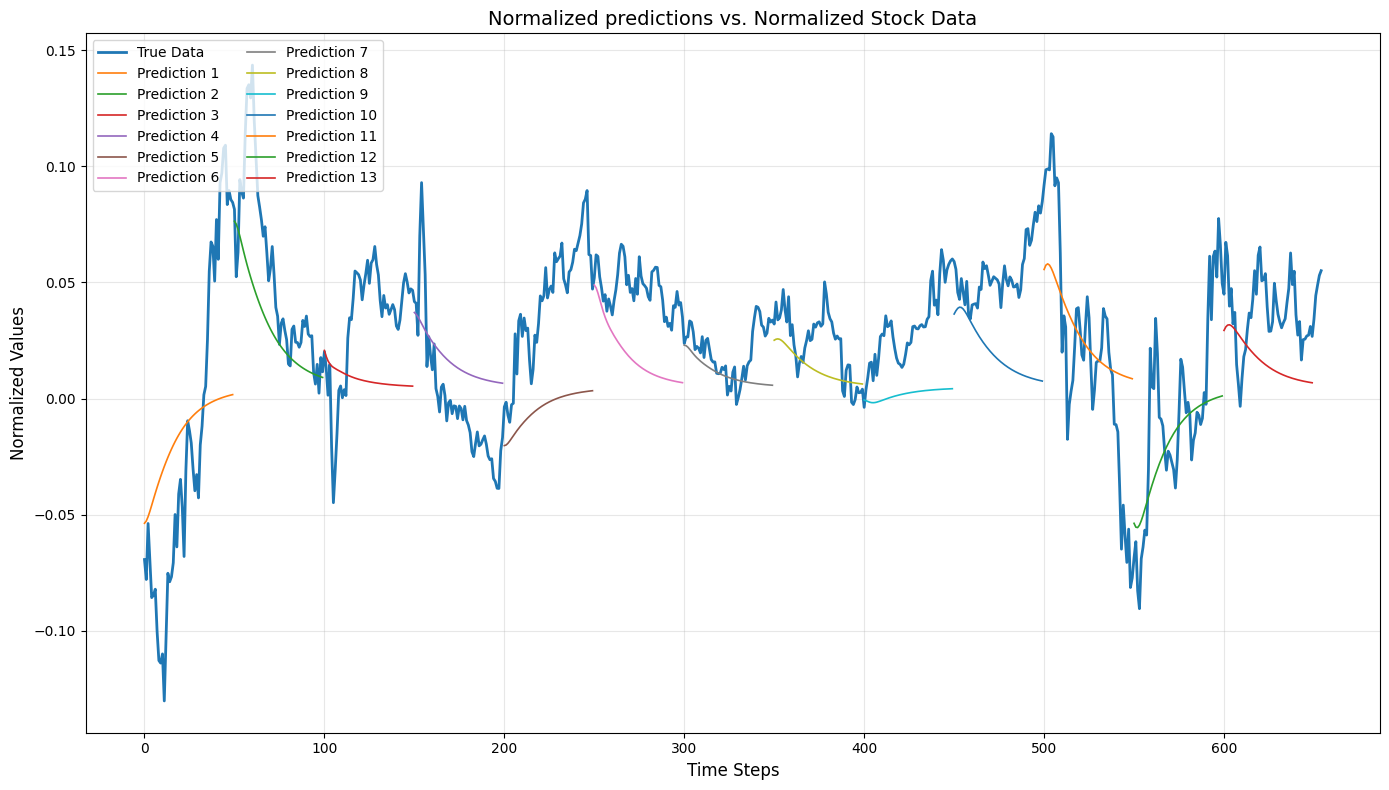

In [ ]:
plot_results_multiple(predictions, y_test, configs['data']['sequence_length'], "Normalized predictions vs. Normalized Stock Data")

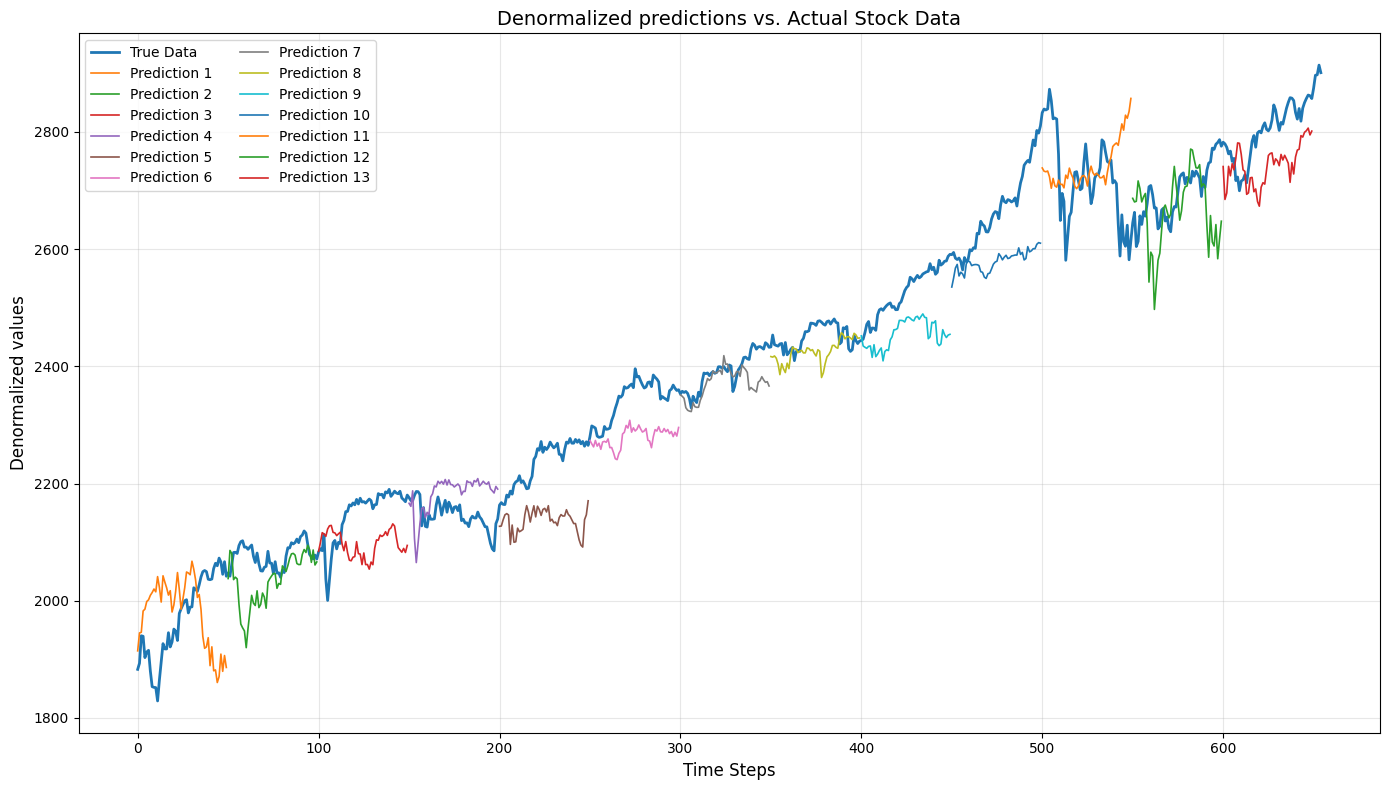

In [ ]:
plot_results_multiple(den_predictions, prey_test, configs['data']['sequence_length'], "Denormalized predictions vs. Actual Stock Data", "Denormalized values")

In [ ]:
seq_len = np.array(den_predictions).shape[1]
begin = 0

# Initialize counters
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

for pred in den_predictions:
    pred_dir = 0
    real_dir = 0

    # Determine predicted direction
    if pred[0] < pred[seq_len - 1]:
        pred_dir = 1  # Predicted upward trend

    # Determine real direction
    if prey_test[begin] < prey_test[begin + seq_len - 1]:
        real_dir = 1  # Actual upward trend

    # Update counters
    if pred_dir == 1 and real_dir == 1:
        tp += 1  # True Positive
    elif pred_dir == 1 and real_dir == 0:
        fp += 1  # False Positive
    elif pred_dir == 0 and real_dir == 0:
        tn += 1  # True Negative
    elif pred_dir == 0 and real_dir == 1:
        fn += 1  # False Negative

    # Update starting index for the next sequence
    begin += seq_len

# Print results
print("True Positives (TP):", tp)
print("False Positives (FP):", fp)
print("True Negatives (TN):", tn)
print("False Negatives (FN):", fn)

True Positives (TP): 9
False Positives (FP): 2
True Negatives (TN): 0
False Negatives (FN): 2
50


# Reality check

In [ ]:
# Algorithm for calculating profit based on trend predictions
seq_len = np.array(den_predictions).shape[1]
begin = 0

profit = 0.0 # Current cash on hand
holding = False  # Track if we currently "hold" a stock
buy_price = prey_test[0]  # Track the price at which we bought the stock
investment_value = profit  # Total value of cash + stock
investment_points = []

# Loop through each sequence (prediction)
for pred in den_predictions:
    pred_dir = 0 # Predicted direction (0 down, 1 up)
    actual_today = prey_test[begin] # Today's actual price (denormalized)

    # Determine predicted direction
    if pred[0] < pred[seq_len - 1]:
        pred_dir = 1  # Predicted upward trend

    # SELL: If prediction is 0 (price decrease) and we are holding
    if pred_dir == 0:
        if holding:
            # Sell the stock and calculate profit
            profit += actual_today
            holding = False  # No longer holding the stock

    # BUY: If prediction is 1 (price increase) and we are not holding
    elif pred_dir == 1:
        if not holding:
            # Buy the stock and record the buy price
            profit -= actual_today
            holding = True  # Now holding the stock


    # Update investment_values
    if holding:
        investment_value = profit + actual_today  # Cash + current stock value
        investment_points.append([begin, investment_value])
        for i in range(begin + 1, begin + seq_len):
            investment_value = profit + prey_test[i]  # Cash + current stock value
            investment_points.append([i, investment_value])
    else:
        investment_value = profit # No stock, so just cash
        investment_points.append([begin, investment_value])
        for i in range(begin + 1, begin + seq_len):
            investment_value = profit  # Cash only if not holding
            investment_points.append([i, investment_value])

    begin += seq_len

# If we're holding a stock at the end, sell it at the last actual price
if holding:
    profit += prey_test[-1]  # Sell the stock
    investment_value = profit  # Final cash value
    investment_points.append([len(prey_test) - 1, investment_value])


print(f"Stock bought initially for: ${buy_price:.2f}")
print(f"Total Profit/Loss: ${profit:.2f}")
print(f"Traded for: {begin} trading days")

final_price = buy_price + profit
years = begin / 252 # Number of trading days in a year
print(f"This equals: {years:.2f} years")

yearly_return = ((final_price / buy_price) ** (1 / years)) - 1
print(f"Average yearly return is: {yearly_return * 100:.2f} %")


Stock bought initially for: $1882.95
Total Profit/Loss: $715.73
Traded for: 650 trading days
This equals: 2.58 years
Average yearly return is: 13.30 %


In [ ]:
# But now, let's calculate what was the stock return:
initial_price = prey_test[0]
total_sum = (prey_test[-1] - prey_test[0])
final_stock_price = initial_price + total_sum

print(f"Actual stock value change: {total_sum:.2f}$")

stock_yearly_return = ((final_stock_price / initial_price) ** (1 / years)) - 1
print(f"Average yearly stock return is: {stock_yearly_return * 100:.2f} %")

Actual stock value change: 1018.18$
Average yearly stock return is: 18.24 %


In [ ]:
# So, was our strategy useful or would it be better if we just bought the stock and didn't touch it at all?
# Calculate the difference between strategy profit and buy-and-hold profit
if profit > total_sum:
    print(f"Your strategy outperformed the buy-and-hold approach by ${profit - total_sum:.2f}.")
    print("This suggests that actively trading based on predictions was more effective.")
else:
    print(f"The buy-and-hold approach outperformed your strategy by ${total_sum - profit:.2f}.")
    print("This suggests that simply buying and holding the stock would have been more profitable.")


The buy-and-hold approach outperformed your strategy by $302.45.
This suggests that simply buying and holding the stock would have been more profitable.


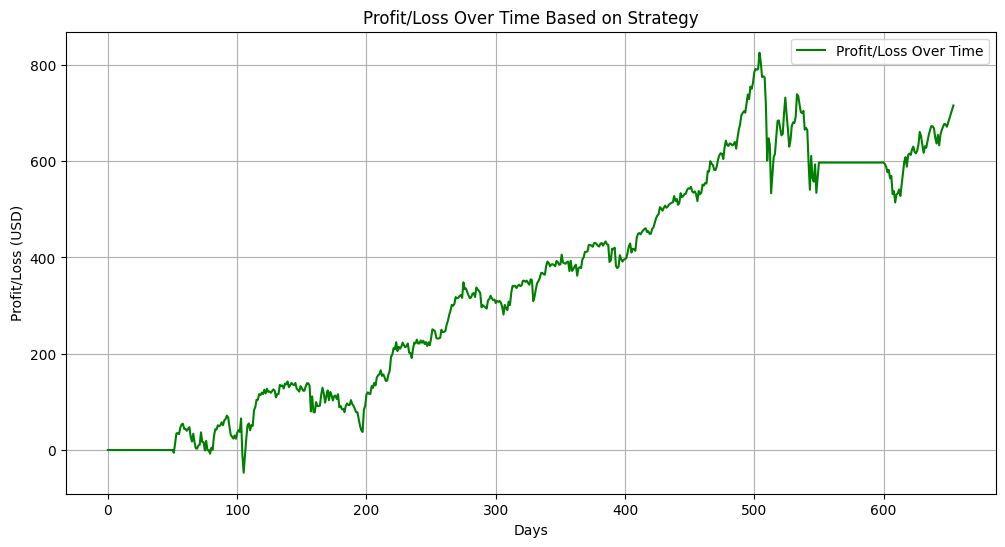

In [ ]:
import matplotlib.pyplot as plt

# Extract the days and corresponding profit values from investment_points
days = [point[0] for point in investment_points]
profits = [point[1] for point in investment_points]

# Plot the investment points
plt.figure(figsize=(12, 6))
plt.plot(days, profits, label='Profit/Loss Over Time', color="green")
plt.title("Profit/Loss Over Time Based on Strategy")
plt.xlabel("Days")
plt.ylabel("Profit/Loss (USD)")
plt.grid(True)
plt.legend()
plt.show()


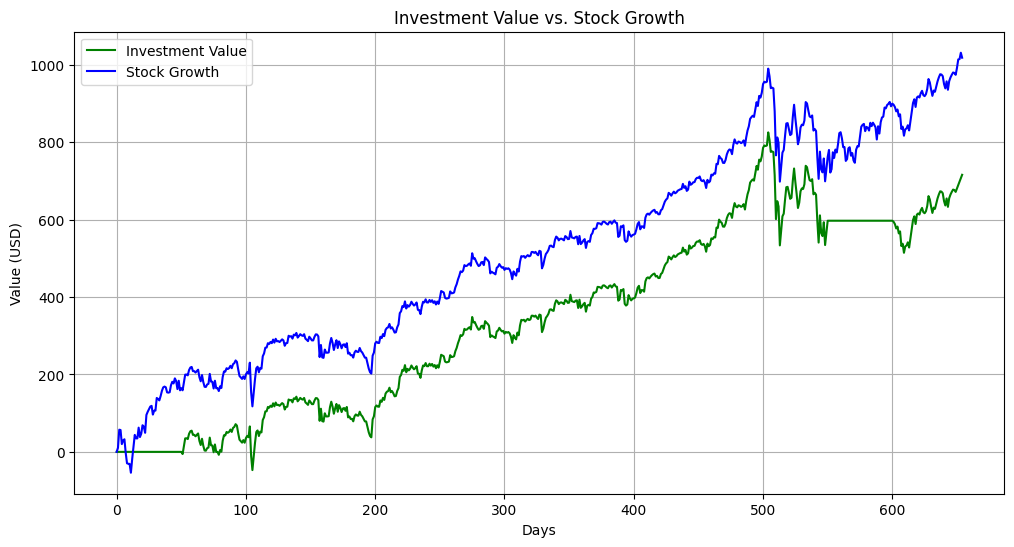

In [ ]:
import matplotlib.pyplot as plt

# Calculate stock growth relative to the initial value
initial_price = prey_test[0]
stock_growth = prey_test - initial_price

# Extract the days and corresponding investment values from investment_points
days = [point[0] for point in investment_points]
investment_values = [point[1] for point in investment_points]

# Plot investment values and stock growth
plt.figure(figsize=(12, 6))

# Plot investment values
plt.plot(days, investment_values, color='green', label='Investment Value')

# Plot stock growth
plt.plot(range(len(stock_growth)), stock_growth, color='blue', label='Stock Growth')

# Add titles and labels
plt.title("Investment Value vs. Stock Growth")
plt.xlabel("Days")
plt.ylabel("Value (USD)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
